# Gaussian Process Classification

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl
import scipy.optimize as so

In [2]:
def kernel(data1,data2,theta,wantderiv=True,measnoise=1.):
    # Uses exp(theta) to ensure positive hyperparams
    theta = np.squeeze(theta)
    theta = np.exp(theta)
    # Squared exponential
    if np.ndim(data1) == 1:
        d1 = np.shape(data1)[0]
        n = 1
        data1 = data1*np.ones((d1,1))
        data2 = data2*np.ones((np.shape(data2)[0],1))
    else:
        (d1,n) = np.shape(data1)

    d2 = np.shape(data2)[0]
    sumxy = np.zeros((d1,d2))
    for d in range(n):
        D1 = np.transpose([data1[:,d]]) * np.ones((d1,d2))
        D2 = [data2[:,d]] * np.ones((d1,d2))
        sumxy += (D1-D2)**2*theta[d+1]

    k = theta[0] * np.exp(-0.5*sumxy)
    if wantderiv:
        K = np.zeros((d1,d2,len(theta)+1))
        # K[:,:,0] is the original covariance matrix
        K[:,:,0] = k + measnoise*theta[2]*np.eye(d1,d2)
        K[:,:,1] = k
        K[:,:,2] = -0.5*k*sumxy
        K[:,:,3] = theta[2]*np.eye(d1,d2)
        return K
    else:
        return k + measnoise*theta[2]*np.eye(d1,d2)

def logPosterior(theta,*args):
    data,targets = args
    (f,logq,a) = NRiteration(data,targets,theta)
    return -logq

def NRiteration(data,targets,theta):
    #print("iteration")
    #pag 46 RASMUSSEN-WILLIAMS
    K = kernel(data,data,theta,wantderiv=False)
    n = np.shape(targets)[0]
    f = np.zeros((n,1))
    tol = 0.1
    phif = 1e100
    scale = 1.
    count = 0
    while True:
        count += 1
        s = np.where(f<0,f,0)
        W = np.diag(np.squeeze(np.exp(2*s - f) / ((np.exp(s) + np.exp(s-f))**2)))
        sqrtW = np.sqrt(W)
        # L = cholesky(B)
        L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW,np.dot(K,sqrtW)))
        p = np.exp(s)/(np.exp(s) + np.exp(s-f))
        b = np.dot(W,f) + 0.5*(targets+1) - p
        a = scale*(b - np.dot(sqrtW,np.linalg.solve(L.transpose(),np.linalg.solve(L,np.dot(sqrtW,np.dot(K,b))))))
        f = np.dot(K,a)
        oldphif = phif
        phif = np.log(p) -0.5*np.dot(f.transpose(),np.dot(np.linalg.inv(K),f)) - 0.5*np.sum(np.log(np.diag(L))) - np.shape(data)[0] /2. * np.log(2*np.pi)
        #print(phif)
        #print("loop",np.sum((oldphif-phif)**2))
        if (np.sum((oldphif-phif)**2) < tol):	
            break
        elif (count > 100):
            count = 0
            scale = scale/2.
    s = -targets*f
    ps = np.where(s>0,s,0)
    #logq = -0.5*np.dot(a.transpose(),f) -np.sum(np.log(ps+np.log(np.exp(-ps) + np.exp(s-ps)))) - np.trace(np.log(L))
    logq = -0.5*np.dot(a.transpose(),f) -np.sum(np.log(ps+np.log(np.exp(-ps) + np.exp(s-ps)))) - sum(np.log(L.diagonal()))
    return (f,logq,a)

def gradLogPosterior(theta,*args):
    data,targets = args
    theta = np.squeeze(theta)
    n = np.shape(targets)[0]
    K = kernel(data,data,theta,wantderiv=True)
    (f,logq,a) = NRiteration(data,targets,theta)
    s = np.where(f<0,f,0)
    W = np.diag(np.squeeze(np.exp(2*s - f) / ((np.exp(s) + np.exp(s-f))**2)))
    sqrtW = np.sqrt(W)
    L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW,np.dot(K[:,:,0],sqrtW)))
    
    R = np.dot(sqrtW,np.linalg.solve(L.transpose(),np.linalg.solve(L,sqrtW)))
    C = np.linalg.solve(L,np.dot(sqrtW,K[:,:,0]))
    p = np.exp(s)/(np.exp(s) + np.exp(s-f))
    hess = -np.exp(2*s - f) / (np.exp(s) + np.exp(s-f))**2
    s2 = -0.5*np.dot(np.diag(np.diag(K[:,:,0]) - np.diag(np.dot(C.transpose(),C))) , 2*hess*(0.5-p))

    gradZ = np.zeros(len(theta))
    for d in range(1,len(theta)+1):
        s1 = 0.5*(np.dot(a.transpose(),np.dot(K[:,:,d],a))) - 0.5*np.trace(np.dot(R,K[:,:,d]))	
        b = np.dot(K[:,:,d],(targets+1)*0.5-p)
        p = np.exp(s)/(np.exp(s) + np.exp(s-f))
        s3 = b - np.dot(K[:,:,0],np.dot(R,b))
        gradZ[d-1] = s1 + np.dot(s2.transpose(),s3)

    return -gradZ

def predict(xstar,data,targets,theta):
    K = kernel(data,data,theta,wantderiv=False)
    n = np.shape(targets)[0]
    kstar = kernel(data,xstar,theta,wantderiv=False,measnoise=0)
    (f,logq,a) = NRiteration(data,targets,theta)
    s = np.where(f<0,f,0)
    W = np.diag(np.squeeze(np.exp(2*s - f) / ((np.exp(s) + np.exp(s-f))**2)))
    sqrtW = np.sqrt(W)
    L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW,np.dot(K,sqrtW)))
    p = np.exp(s)/(np.exp(s) + np.exp(s-f))
    fstar = np.dot(kstar.transpose(), (targets+1)*0.5 - p)
    v = np.linalg.solve(L,np.dot(sqrtW,kstar))	
    V = kernel(xstar,xstar,theta,wantderiv=False,measnoise=0)-np.dot(v.transpose(),v) 
    return (fstar,V)

In [3]:
data = np.array([[-2.1, -2.0, -1.9, -0.1, 0., 0.1, 1.9, 2.0, 2.1 ]]).transpose()
labels = np.array([[-1., -1., -1., 1., 1., 1., -1., -1., -1. ]]).transpose() 

test = np.array([[-2.2, -2.05, -1.8, -0.2, 0.05, 0.15, 1.8, 2.05, 2.01 ]]).transpose()
tlabels = np.array([[-1., -1., -1., 1., 1., 1., -1., -1., -1. ]]).transpose()

lengthscale = 0.742025
constantscale = 1.04431
noise_scale = -2.125

theta =np.zeros((3,1))
theta[0] = constantscale
theta[1] = lengthscale
theta[2] = noise_scale

In [4]:
newtheta = so.fmin_cg(logPosterior, theta, fprime=gradLogPosterior, args=(data,labels), gtol=1e-4,maxiter=100,disp=1, full_output=0)
print(newtheta, logPosterior(newtheta,data,labels))

         Current function value: -11.962111
         Iterations: 0
         Function evaluations: 86
         Gradient evaluations: 74
[ 1.04431   0.742025 -2.125   ] [[-11.96211115]]


In [5]:
xstar = np.reshape(np.linspace(-5,5,100),(100,1))
kstar = kernel(xstar, data, newtheta, wantderiv=False,measnoise=False)
K = kernel(data,data,newtheta,wantderiv=False)
kstarstar = kernel(xstar,xstar, newtheta, wantderiv=False, measnoise=False)
kstarstar_diag = kstarstar.diagonal()

In [6]:

invk = np.linalg.inv(K)
mean = np.dot(kstar,np.dot(invk,labels))
var = kstarstar_diag - np.diag(np.dot(kstar,np.dot(invk,kstar.transpose())))
var = np.reshape(var,(100,1))

[-5, 5, -3, 3]

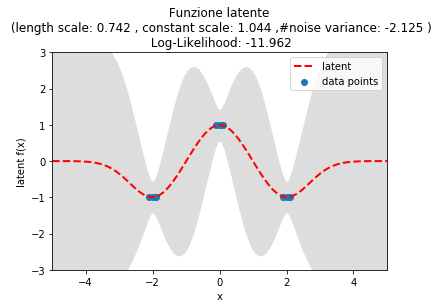

In [7]:
xstar_p = np.squeeze(xstar)
mean_p = np.squeeze(mean)
var_p = np.squeeze(np.reshape(var,(len(xstar),1)))
s = np.sqrt(var_p)

pl.figure()
pl.clf()

pl.gca().fill_between(xstar_p,mean_p - 2*s,mean_p +2*s,color="#dddddd")
latent, = pl.plot(xstar, mean, 'r--', lw=2, label = "latent")
pl.title('')
loglikelihood = logPosterior(newtheta, data, labels)
pl.title(' Funzione latente \n (length scale: %.3f , constant scale: %.3f ,\
#noise variance: %.3f )\n Log-Likelihood: %.3f'
        % (newtheta[1], newtheta[0], newtheta[2], loglikelihood))
pl.xlabel('x')
pl.ylabel('latent f(x)')
datapoints = pl.scatter(data,labels, label = "data points")
pl.legend(handles = [latent, datapoints])
pl.savefig('predict.png', bbox_inches='tight')
pl.axis([-5, 5, -3, 3])

In [8]:
pred = np.squeeze(np.array([predict(np.reshape(i,(1,1)),data,labels,newtheta) for i in test]))
output = np.reshape(np.where(pred[:,0]<0,-1,1),(9,1))

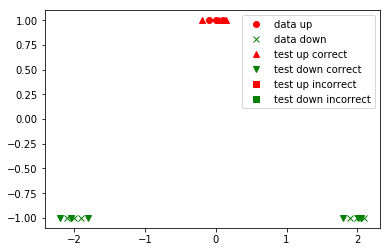

In [9]:
pl.figure()
which = np.where(labels==1)
data_up, = pl.plot(data[which],labels[which],'ro',label="data up")
which = np.where(labels==-1)
data_down, = pl.plot(data[which],labels[which],'gx', label= "data down")

which = np.where((tlabels==1) & (output==1))
test_up_ok, = pl.plot(test[which],tlabels[which],'r^', label= "test up correct")
which = np.where((tlabels==-1) & (output==-1))
test_down_ok, = pl.plot(test[which],tlabels[which],'gv', label= "test down correct")

which = np.where((tlabels==1) & (output==-1))
test_up_wrong, = pl.plot(test[which],tlabels[which],'rs', label = "test up incorrect")
which = np.where((tlabels==-1) & (output==1))
test_down_wrong, = pl.plot(test[which],tlabels[which],'gs', label = "test down incorrect")
pl.legend(handles=[data_up, data_down, test_up_ok, test_down_ok,
                   test_up_wrong, test_down_wrong])

In [10]:
pred2 = np.squeeze(np.array([predict(np.reshape(i,(1,1)),data,labels,newtheta) for i in xstar]))
xstar_p = np.squeeze(xstar)
mean_p = np.squeeze(mean)
var_p = np.squeeze(np.reshape(var,(len(xstar),1)))
s = np.sqrt(var_p)

[-5, 5, -3, 3]

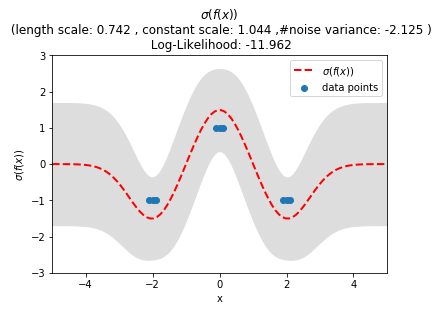

In [11]:
pl.figure()
pl.clf()

pl.gca().fill_between(xstar_p,np.squeeze(pred2[:,0]-np.sqrt(pred2[:,1])),np.squeeze(pred2[:,0]+np.sqrt(pred2[:,1])),color="#dddddd")
latent, = pl.plot(xstar, pred2[:,0], 'r--', lw=2, label = "$\sigma(f(x))$")
loglikelihood = logPosterior(newtheta, data, labels)
pl.title('$\sigma(f(x))$ \n (length scale: %.3f , constant scale: %.3f ,\
#noise variance: %.3f )\n Log-Likelihood: %.3f'
        % (newtheta[1], newtheta[0], newtheta[2], loglikelihood))
pl.xlabel('x')
pl.ylabel('$\sigma(f(x))$')
datapoints = pl.scatter(data,labels, label = "data points")
pl.legend(handles = [latent, datapoints])
#pl.scatter(test,tlabels)
pl.savefig('predict.png', bbox_inches='tight')
pl.axis([-5, 5, -3, 3])